# Bajar imágenes de la web usando `Selenium` con `Python` y convertirlas en un `Dataset` de `PyTorch`

El aprendizaje automático está impulsando los desarrollos tecnológicos actuales, como los automóviles sin conductor, los vuelos espaciales, la imagen y el reconocimiento de voz. Sin embargo, un profesional de la ciencia de datos necesita un gran volumen de datos para crear un modelo de aprendizaje automático sólido y confiable para tales problemas comerciales.

La extracción o recopilación de datos es el primer paso en el ciclo de vida de la ciencia de datos. Según los requisitos comerciales, es posible que deba recopilar datos de fuentes como servidores SAP, registros, bases de datos, API, repositorios en línea o web.

Las herramientas para web scraping como Selenium pueden extraer un gran volumen de datos, como texto e imágenes, en un tiempo relativamente corto.

Posteriormente a la extracción de los datos estos se deben almacenar en un formato que sea compatible con los `Dataset`'s de `PyTorch`

## 1.0 ¿Qué es el Web Scrapping?

Web Scrapping, también llamado *Crawling* o *Spidering*, es la técnica para recopilar datos automáticamente de una fuente en línea, generalmente de un sitio web. Si bien Web Scrapping es una manera fácil de obtener un gran volumen de datos en un período de tiempo relativamente corto, agrega estrés al servidor donde se aloja la fuente.

Esta es también una de las razones principales por las que muchos sitios web no permiten raspar todo en su sitio web. Sin embargo, siempre que no interrumpa la función principal de la fuente en línea, es bastante aceptable.

## 1.1 ¿Qué es Selenium?

Selenium es una herramienta de automatización basada en web de código abierto. El Selenium se usa principalmente para pruebas en la industria, pero también se puede usar para web scraping. Usaremos el navegador Chrome pero puedes probar en cualquier navegador, es casi lo mismo.

## 1.2 Instalar GoogleDriver para utilizar Selenium con Google Chrome

- Identifica tu versión de Chrome. Normalmente se encuentra haciendo clic en Acerca de Google Chrome. Actualmente tengo la versión 106.0.5249.103 (mi versión principal es 106, el número antes del primer punto).
- Descargue el ChromeDriver correspondiente desde [aquí](https://chromedriver.chromium.org/downloads) para su versión principal y coloque la ubicación del ejecutable en el `$PATH` de la computadora
- Instale el paquete de Python Selenium a través de `pip` o `conda`

In [11]:
# Instalar selenium usando pip
!pip install selenium

In [12]:
# Instalar selenium usando conda
!conda install -c conda-forge selenium

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done


## 2.0 Formato para almacenar las imágenes de manera que se puedan utilizar con el `Dataset` de `PyTorch`

El formato de clasificación de imágenes contiene clases separadas de imágenes en directorios separados titulados con un nombre de clase particular.

Por ejemplo, todas las imágenes de `oso_hormiguero` están contenidas en el directorio `oso_hormiguero/`.

Este formato es popular en muchos puntos de referencia de clasificación de imágenes diferentes, incluido [ImageNet](https://www.image-net.org/) (de los conjuntos de datos de punto de referencia de visión artificial más populares).

Puede ver un ejemplo del formato de almacenamiento a continuación, los números de las imágenes son arbitrarios.

```
perezoso-hormiguero/ <- carpeta del conjunto de datos general
    entrenamiento/ <- imágenes de entrenamiento
        oso_hormiguero/ <- nombre de clase como nombre de carpeta
            imagen01.jpeg
            imagen02.jpeg
            ...
        oso_perezoso/
            imagen24.jpeg
            imagen25.jpeg
            ...
    prueba/ <- imágenes de prueba
        oso_hormiguero/
            imagen101.jpeg
            imagen102.jpeg
            ...
        oso_perezoso/
            imagen154.jpeg
            imagen155.jpeg
            ...
```

El objetivo será **tomar esta estructura de almacenamiento de datos y convertirla en un conjunto de datos utilizable con PyTorch**.

> **Nota:** La estructura de los datos con los que trabaja variará según el problema en el que esté trabajando. Pero la premisa sigue siendo: buscar los datos y luego encontrar la mejor manera de convertirlos en un conjunto de datos compatible con PyTorch.

## Importar las librerías necesarias

In [10]:
import selenium
import os
import time
import io
import hashlib
import requests
from PIL import Image
from selenium import webdriver
from selenium.webdriver.common.by import By

In [14]:
wd = webdriver.Chrome(executable_path='/Users/wladimir/Documents/Cursos/chromedriver')

/var/folders/x4/__tc8h0d0rs9324_8_zvtysh0000gn/T/ipykernel_5115/1509332257.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  wd = webdriver.Chrome(executable_path='/Users/wladimir/Documents/Cursos/chromedriver')


In [17]:
wd.get('https://google.com')

In [19]:
caja_de_busqueda = wd.find_element(By.CSS_SELECTOR, 'input.gLFyf')
caja_de_busqueda.send_keys('Dogs')

### 3.0 Definir una función para buscar los URL de las imágenes

In [11]:
def buscar_imagen_urls(consulta:str, max_enlaces_a_buscar:int, wd:webdriver, pausa_entre_interacciones:int=1):    
    
    # construir la consulta en google
    consulta_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # cargar la página
    wd.get(consulta_url.format(q=consulta))

    imagen_urls = set()
    imagen_contador = 0
    resultados_inicio = 0
    while imagen_contador < max_enlaces_a_buscar:
        # Ir al final de la página
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(pausa_entre_interacciones)

        # obtener todos los resultados de las miniaturas de las imágenes
        miniatura_resultados = wd.find_elements(By.CSS_SELECTOR, "img.Q4LuWd")
        total_resultados = len(miniatura_resultados)
        
        print(f"Encontrados: {total_resultados} resultados consulta. Extrayendo enlaces desde {resultados_inicio}:{total_resultados}")
        
        for imagen in miniatura_resultados[resultados_inicio:total_resultados]:
            # tratar de hacer click en cada miniatura para obtener la imagen real
            try:
                imagen.click()
                time.sleep(pausa_entre_interacciones)
            except Exception:
                continue

            # extraer el url de las imágenes
            imagenes_actuales = wd.find_elements(By.CSS_SELECTOR, 'img.n3VNCb')
            for imagen_actual in imagenes_actuales:
                if imagen_actual.get_attribute('src') and 'http' in imagen_actual.get_attribute('src'):
                    imagen_urls.add(imagen_actual.get_attribute('src'))

            imagen_contador = len(imagen_urls)

            if len(imagen_urls) >= max_enlaces_a_buscar:
                print(f"Encontrados: {len(imagen_urls)} enlaces a imagenes, listo!")
                break
        else:
            print(f"Encontrados: {len(imagen_urls)} enlaces a imagenes, buscando más ...")
            time.sleep(30)
            #return
            boton_cargar_mas = wd.find_element(By.CSS_SELECTOR, ".mye4qd")
            if boton_cargar_mas:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # mover el punto de partida más abajo
        resultados_inicio = len(miniatura_resultados)

    return imagen_urls

### 3.1 Definir una función para guardar las imágenes

In [12]:
def guardar_image(ruta_directorio:str, url:str):
    try:
        contenido_imagen = requests.get(url).content

    except Exception as e:
        print(f"ERROR - No se pudo bajar {url} - {e}")

    try:
        archivo_imagen = io.BytesIO(contenido_imagen)
        imagen = Image.open(archivo_imagen).convert('RGB')
        ruta_archivo = os.path.join(ruta_directorio,hashlib.sha1(contenido_imagen).hexdigest()[:10] + '.jpg')
        with open(ruta_archivo, 'wb') as f:
            imagen.save(f, "JPEG", quality=85)
        print(f"EXITO - Almacenado {url} - como {ruta_archivo}")
    except Exception as e:
        print(f"ERROR - No se pudo almacenar {url} - {e}")

### 3.2 Definir una función para buscar y bajar las imágenes

In [13]:
def busqueda_y_bajada(termino_busqueda:str,ruta_driver:str,ruta_destino='../datos',numero_imagenes=10):
    directorio_destino = os.path.join(ruta_destino,'_'.join(termino_busqueda.lower().split(' ')))

    if not os.path.exists(directorio_destino):
        os.makedirs(directorio_destino)

    with webdriver.Chrome(executable_path=ruta_driver) as wd:
        resultado = buscar_imagen_urls(termino_busqueda, numero_imagenes, wd=wd, pausa_entre_interacciones=0.5)
        
    for elemento in resultado:
        guardar_image(directorio_destino,elemento)

### 3.3 Buscar 50 imagenes de entrenamiento y 10 de prueba para la clase Oso Hormiguero

In [14]:
RUTA_DRIVER = '/Users/wladimir/Documents/Cursos/chromedriver'
termino_busqueda = 'Oso hormiguero'

busqueda_y_bajada(
    termino_busqueda=termino_busqueda,
    ruta_driver=RUTA_DRIVER,
    ruta_destino='../datos/perezoso-hormiguero/entrenamiento',
    numero_imagenes=50)

busqueda_y_bajada(
    termino_busqueda=termino_busqueda,
    ruta_driver=RUTA_DRIVER,
    ruta_destino='../datos/perezoso-hormiguero/prueba',
    numero_imagenes=10)

/var/folders/x4/__tc8h0d0rs9324_8_zvtysh0000gn/T/ipykernel_7757/1618089782.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  with webdriver.Chrome(executable_path=ruta_driver) as wd:


Encontrados: 100 resultados consulta. Extrayendo enlaces desde 0:100
Encontrados: 50 enlaces a imagenes, listo!
EXITO - Almacenado https://www.lanacion.com.ar/resizer/HTJ6j30sr2LMtxS9xVOv212bEHo=/309x206/smart/filters:format(webp):quality(80)/cloudfront-us-east-1.images.arcpublishing.com/lanacionar/P2AU56UUZJF7LGJOWIYWYR37PY.jpg - como ../datos/perezoso-hormiguero/entrenamiento/oso_hormiguero/c5094bc7f3.jpg
EXITO - Almacenado https://www.zoomadrid.com/content/dam/zoo/images/animals/oso-hormiguero/Oso-hormiguero-Zoo-Madrid-main.jpg - como ../datos/perezoso-hormiguero/entrenamiento/oso_hormiguero/0b0d587f7e.jpg
EXITO - Almacenado https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSjd9NcFQ4yk71JLFhr1ATST9q05BIOODknTA&usqp=CAU - como ../datos/perezoso-hormiguero/entrenamiento/oso_hormiguero/937cfaeff8.jpg
EXITO - Almacenado https://image.shutterstock.com/image-vector/anteater-on-white-background-illustration-260nw-1208724931.jpg - como ../datos/perezoso-hormiguero/entrenamiento/oso_horm

### 3.4 Buscar 50 imagenes de entrenamiento y 10 de prueba para la clase Oso Perezoso

/var/folders/x4/__tc8h0d0rs9324_8_zvtysh0000gn/T/ipykernel_7757/1618089782.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  with webdriver.Chrome(executable_path=ruta_driver) as wd:


Encontrados: 100 resultados consulta. Extrayendo enlaces desde 0:100
Encontrados: 51 enlaces a imagenes, listo!
EXITO - Almacenado https://s1.eestatic.com/2021/08/30/ciencia/medio-ambiente/608201208_203739946_1024x576.jpg - como ../datos/perezoso-hormiguero/entrenamiento/oso_perezoso/d0a9cacf5e.jpg
EXITO - Almacenado https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTa6fUVAKh3cN2YaAcJ51O3Vdfg2LS4gJmLcg&usqp=CAU - como ../datos/perezoso-hormiguero/entrenamiento/oso_perezoso/e71cad3afc.jpg
EXITO - Almacenado https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR_uMBqrYUScgRUDmiFtfp41gUZvOfSwSz6ow&usqp=CAU - como ../datos/perezoso-hormiguero/entrenamiento/oso_perezoso/5821eb90c2.jpg
ERROR - No se pudo bajar  - No connection adapters were found for ''
ERROR - No se pudo almacenar  - local variable 'contenido_imagen' referenced before assignment
EXITO - Almacenado https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRkict9-QmE8TRXZnxTxYlSX3EEvIH-r1xFwA&usqp=CAU - como ../datos/perezos
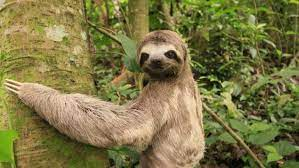
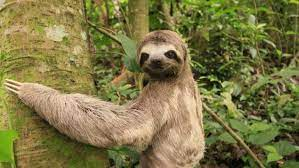
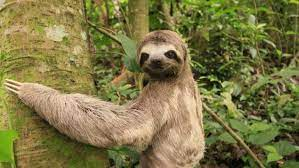
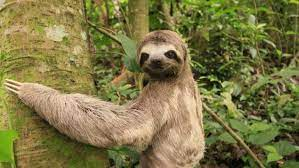
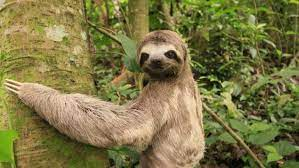
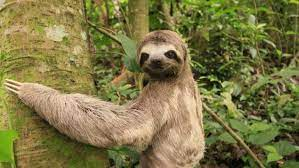

In [15]:
termino_busqueda = 'Oso perezoso'

busqueda_y_bajada(
    termino_busqueda=termino_busqueda,
    ruta_driver=RUTA_DRIVER,
    ruta_destino='../datos/perezoso-hormiguero/entrenamiento',
    numero_imagenes=50)

busqueda_y_bajada(
    termino_busqueda=termino_busqueda,
    ruta_driver=RUTA_DRIVER,
    ruta_destino='../datos/perezoso-hormiguero/prueba',
    numero_imagenes=10)

### 2.1 Visualizar una imagen

Después de buscar y almacenar las imagenes a utilizar.

Vamos a visualizar una imagen:

1. Obtenga todas las rutas de la imagen usando [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) para encontrar todas las archivos que terminan en `.jpg`.
2. Elija una ruta de imagen aleatoria utilizando [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice) de Python.
3. Obtenga el nombre de la clase de imagen usando [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
4. Y dado que estamos trabajando con imágenes, abriremos la ruta de la imagen aleatoria usando [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image. html#PIL.Image.open) (PIL significa Librería de imágenes de Python).
5. Luego mostraremos la imagen e imprimiremos algunos metadatos.

../datos/perezoso-hormiguero directory exists.
Ruta imagen aleatoria: ../datos/perezoso-hormiguero/entrenamiento/oso_perezoso/ae6c78e31d.jpg
Clase imagen: oso_perezoso
Image height: 283
Image width: 178


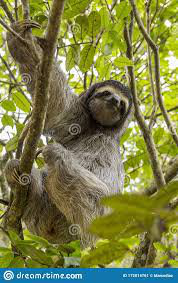

In [18]:
import random
from PIL import Image
from pathlib import Path

# Setup path to data folder
ruta_datos = Path("../datos/")
ruta_imagenes = ruta_datos / "perezoso-hormiguero"

# Inicializar generador de números aleatorios
random.seed(42)

# 1. Obtener todas las rutas de imágenes (* significa "cualquier combinación")
lista_rutas_imagenes = list(ruta_imagenes.glob("*/*/*.jpg"))

# 2. Obtener una ruta de imagen aleatoria
ruta_imagen_aleatoria = random.choice(lista_rutas_imagenes)

# 3. Obtener la clase de la imagen del nombre de la ruta (la clase es el nombre del directorio)
clase_imagen = ruta_imagen_aleatoria.parent.stem

# 4. Abrir imagen
imagen = Image.open(ruta_imagen_aleatoria)

# 5. Imprimir metadata
print(f"Ruta imagen aleatoria: {ruta_imagen_aleatoria}")
print(f"Clase imagen: {clase_imagen}")
print(f"Image height: {imagen.height}") 
print(f"Image width: {imagen.width}")
imagen

In [19]:
# Setup train and testing paths
directorio_entrenamiento = ruta_imagenes / "entrenamiento"
directorio_prueba = ruta_imagenes / "prueba"

directorio_entrenamiento, directorio_prueba

(PosixPath('../datos/perezoso-hormiguero/entrenamiento'),
 PosixPath('../datos/perezoso-hormiguero/prueba'))

## 4. Transformación de datos

Ahora, ¿qué pasaría si quisiéramos cargar nuestros datos de imagen en PyTorch?

Antes de que podamos usar nuestros datos de imagen con PyTorch, necesitamos:

1. Convertirlo en tensores (representaciones numéricas de nuestras imágenes).
2. Conviértalo en `torch.utils.data.Dataset` y, posteriormente, en `torch.utils.data.DataLoader`; los llamaremos `Dataset` y `DataLoader` para abreviar.

Hay varios tipos diferentes de conjuntos de datos prediseñados y cargadores de conjuntos de datos para PyTorch, según el problema en el que esté trabajando.

| **Espacio de problemas** | **Conjuntos de datos y funciones preconstruidos** |
| ----- | ----- |
| **Visión** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Texto** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Sistema de recomendaciones** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

Como estamos trabajando con un problema de visión, buscaremos `torchvision.datasets` para nuestras funciones de carga de datos, así como [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) para preparar nuestros datos.

Importemos algunas librerías.

In [20]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 4.1 Transformación de datos con `torchvision.transforms`

Tenemos carpetas de imágenes, pero antes de que podamos usarlas con PyTorch, debemos convertirlas en tensores.

Una de las formas en que podemos hacer esto es usando el módulo `torchvision.transforms`.

`torchvision.transforms` contiene muchos métodos preconstruidos para formatear imágenes, convertirlas en tensores e incluso manipularlas para el propósito de **aumento de datos** (la práctica de alterar datos para que sea más difícil de aprender para un modelo)

Para obtener experiencia con `torchvision.transforms`, escribamos una serie de pasos de transformación que:
1. Cambie el tamaño de las imágenes usando [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) (de aproximadamente 512x512 a 64x64 , la misma forma que las imágenes en el [sitio web de CNN Explainer](https://poloclub.github.io/cnn-explainer/)).
2. Voltear nuestras imágenes al azar horizontalmente usando [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) (este podría considerarse una forma de aumento de datos porque cambiará artificialmente nuestros datos de imagen).
3. Convertir nuestras imágenes de una imagen PIL a un tensor PyTorch usando [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

Podemos compilar todos estos pasos usando [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose).

In [21]:
# Escribir el transformador de imágenes
data_transform = transforms.Compose([
    # Cambiar tamaño de las imágenes a 64x64
    transforms.Resize(size=(64, 64)),
    # Voltear horizontalmente de manera aleatoria las imágenes
    transforms.RandomHorizontalFlip(p=0.5), # p = probabilidad de voltear, 0.5 = 50% de probabilidad
    # Convertir la imagen a un torch.Tensor
    transforms.ToTensor() # esto también combierte los valores de los pixeles de 0 a 255 a valores entre 0.0 and 1.0 
])

### 4.2 Carga de datos de imagen mediante [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)

Muy bien, es hora de convertir nuestros datos de imagen en un 'Conjunto de datos' capaz de usarse con PyTorch.

Dado que nuestros datos están en formato de clasificación de imágenes estándar, podemos usar la clase [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)

Donde podemos pasarle la ruta del archivo de un directorio de imágenes de destino, así como una serie de transformaciones que nos gustaría realizar en nuestras imágenes.

Probémoslo en nuestras carpetas de datos `directorio_entrenamiento` y `directorio_prueba` pasando `transform=data_transform` para convertir nuestras imágenes en tensores.

In [22]:
# Usar ImageFolder para crear los conjuntos de datos
from torchvision import datasets
data_entrenamiento = datasets.ImageFolder(root=directorio_entrenamiento, # directorio de las imágenes
                                  transform=data_transform, # transformaciones a realizar sobre los datos (imágenes)
                                  target_transform=None) # transformaciones a realizar sobre las etiquetas (si es necesario)

data_prueba = datasets.ImageFolder(root=directorio_prueba, 
                                 transform=data_transform)

print(f"Data entrenamiento:\n{data_entrenamiento}\nData prueba:\n{data_prueba}")

Data entrenamiento:
Dataset ImageFolder
    Number of datapoints: 100
    Root location: ../datos/perezoso-hormiguero/entrenamiento
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Data prueba:
Dataset ImageFolder
    Number of datapoints: 19
    Root location: ../datos/perezoso-hormiguero/prueba
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [23]:
# Obtener los nombres de las clases como una lista
nombre_clases = data_entrenamiento.classes
nombre_clases

['oso_hormiguero', 'oso_perezoso']

In [24]:
# Obtener los nombres de las clases como un diccionario
diccionario_clases = data_entrenamiento.class_to_idx
diccionario_clases

{'oso_hormiguero': 0, 'oso_perezoso': 1}

### 4.3 Convertir las imágenes cargadas en `DataLoader`'s

Tenemos nuestras imágenes como PyTorch `Dataset`'s pero ahora vamos a convertirlas en `DataLoader`'s.

Lo haremos usando [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

Convertir nuestros `Dataset` en `DataLoader` los hace iterables para que un modelo pueda aprender las relaciones entre muestras y objetivos (características y etiquetas).

Para simplificar las cosas, usaremos `batch_size=1` y `num_workers=1`.

¿Qué es `num_workers`?

Define cuántos subprocesos se crearán para cargar sus datos.

Piénselo de esta manera, cuanto mayor sea el valor de `num_workers`, más potencia informática utilizará PyTorch para cargar sus datos.

Personalmente, generalmente lo configuro en la cantidad total de CPU en mi máquina a través de Python [`os.cpu_count()`](https://docs.python.org/3/library/os.html#os.cpu_count).

Esto asegura que `DataLoader` reclute tantos núcleos como sea posible para cargar datos.

> **Nota:** Hay más parámetros con los que puede familiarizarse usando `torch.utils.data.DataLoader` en la [documentación de PyTorch](https://pytorch.org/docs/stable/data.html#torch .utils.data.DataLoader).

In [25]:
# Convertir los conjuntos de datos de entrenamiento y prueba en DataLoaders
from torch.utils.data import DataLoader
cargador_entrenamiento = DataLoader(dataset=data_entrenamiento, 
                              batch_size=1, # cuantos ejemplos por lote?
                              num_workers=1, # cuantos subprocesos usar para cargar la data?
                              shuffle=True) # barajar la data?

cargador_prueba = DataLoader(dataset=data_prueba, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # usualmente no es necesario barajar la data de prueba

cargador_entrenamiento, cargador_prueba

(<torch.utils.data.dataloader.DataLoader at 0x16a330e20>,
 <torch.utils.data.dataloader.DataLoader at 0x16a330f70>)

Ahora nuestros datos son iterables.

Vamos a probarlo y comprobar las formas.

In [26]:
imagen, etiqueta = next(iter(cargador_entrenamiento))

# Tamaño lote es 1, puedes cambiar el parametro batch_size parámetro arriba a ver que pasa
print(f"Forma imagen: {imagen.shape} -> [batch_size, canales_color, altura, ancho]")
print(f"Forma etiqueta: {etiqueta.shape}")

Forma imagen: torch.Size([1, 3, 64, 64]) -> [batch_size, canales_color, altura, ancho]
Forma etiqueta: torch.Size([1])


## 5. Crear clase de modelo TinyVGG

En el notebook 23-RedneuronalConvolucional_2 usamos el modelo TinyVGG del [sitio web de CNN Explainer] (https://poloclub.github.io/cnn-explainer/).

Recreemos el mismo modelo, excepto que esta vez usaremos imágenes en color en lugar de escala de grises (`in_channels=3` en lugar de `in_channels=1` para píxeles RGB).

In [32]:
from torch import nn, optim

class TinyVGG(nn.Module):
    """
    Arquitectura del modelo basada en TinyVGG: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, forma_entrada: int, unidades_ocultas: int, forma_salida: int):
        super().__init__()
        self.bloque_1 = nn.Sequential(
            nn.Conv2d(in_channels=forma_entrada, 
                      out_channels=unidades_ocultas, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=unidades_ocultas, 
                      out_channels=unidades_ocultas,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.bloque_2 = nn.Sequential(
            nn.Conv2d(unidades_ocultas, unidades_ocultas, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(unidades_ocultas, unidades_ocultas, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.clasificador = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=unidades_ocultas*16*16, 
                      out_features=forma_salida)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.bloque_1(x)
        x = self.bloque_2(x)
        x = self.clasificador(x)
        return x

In [72]:
# Fijar dispositivo GPU o CPU
if torch.backends.mps.is_available():
    dispositivo = 'mps'
elif torch.cuda.is_available():
    dispositivo = "cuda"
else: "cpu"
dispositivo

'mps'

In [73]:
torch.manual_seed(42)
modelo = TinyVGG(forma_entrada=3, # número de canales de colores (3 para RGB) 
                  unidades_ocultas=10, 
                  forma_salida=len(data_entrenamiento.classes)).to(dispositivo)
modelo

TinyVGG(
  (bloque_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bloque_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clasificador): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=2, bias=True)
  )
)

### 5.1 Usar `torchinfo` para tener una idea de las formas que atraviesan nuestro modelo

Imprimir nuestro modelo con `print(model)` nos da una idea de lo que está pasando con nuestro modelo.

Y podemos imprimir las formas de nuestros datos a través del método `forward()`.

Sin embargo, una forma útil de obtener información de nuestro modelo es usar [`torchinfo`](https://github.com/TylerYep/torchinfo).

`torchinfo` viene con un método `summary()` que toma un modelo PyTorch así como `input_shape` y devuelve lo que sucede cuando un tensor se mueve a través de su modelo.

> **Nota:** Si está utilizando Google Colab, deberá instalar `torchinfo`.

In [35]:
# Instalar torchinfo isi no esta disponible, importar si esta disponible
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(modelo, input_size=[1, 3, 64, 64]) # hacer un paso de prueba de un ejemplo de tamaño de entrada

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 5.2 Función para realizar paso de entrenamiento del modelo

In [83]:
def paso_entrenamiento(modelo, 
             dataloader,
             perdida_fn, 
             optimizador):
    # Colocar modelo en modo entrenamiento
    modelo.train()
    
    # Inicializar valores de perdida y exactitud del entrenamiento
    perdida_entrenamiento, exactitud_entrenamiento = 0, 0
    
    # Iterar sobre los lotes del DataLoader
    for imagenes, etiquetas in dataloader:
        
        # Enviar datos al dispositivo
        imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
    
        # 1. Propagar hacia adelante los datos de entrenamiento usando el método forward()
        salida = modelo(imagenes)
        
        # 2. Calcule la pérdida (qué tan diferentes son las predicciones de nuestros modelos con respecto a la verdad del terreno)
        perdida = perdida_fn(salida, etiquetas)
        perdida_entrenamiento += perdida.item() 
        
        # 3. Colocar a cero los gradientes del optimizador
        optimizador.zero_grad()
        
        # 4. Propagación hacia atrás
        perdida.backward()
        
        # 5. Realizar paso de optimización
        optimizador.step()
        
        # Calcular y acumular la exactitud sobre todos los lotes
        clase_predicha = torch.argmax(torch.softmax(salida, dim=1), dim=1)
        exactitud_entrenamiento += (clase_predicha == etiquetas).sum().item()/len(salida)
    
    # Ajustar métricas para obtener un promedio de la perdida y la exactitud por lote
    perdida_entrenamiento /= len(dataloader)
    exactitud_entrenamiento /= len(dataloader)

    return perdida_entrenamiento, exactitud_entrenamiento

### 5.3 Función para realizar paso de validación del modelo

In [84]:
def paso_validacion(modelo,
            dataloader,
            perdida_fn):
        
    # Colocar el modelo en modo evaluación
    modelo.eval()

    # Inicializar valores de perdida y exactitud de la validación
    perdida_validacion, exactitud_validacion = 0, 0
    
    # Iniciar el manejador de contexto para inferencia
    with torch.inference_mode():
        # Iterar sobre los lotes del DataLoader
        for imagenes, etiquetas in dataloader:
            # Enviar datos al dispositivo
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            
            # 1. Propagar hacia adelante los datos de entrenamiento usando el método forward()
            salida = modelo(imagenes)
            
            # 2. Calcular y acumular la pérdida
            perdida = perdida_fn(salida, etiquetas)
            perdida_validacion += perdida.item()
            
            # 3. Calcular y acumular la exactitud
            clases_predicha = salida.argmax(dim=1)
            exactitud_validacion += ((clases_predicha == etiquetas).sum().item()/len(salida))
            
    # Ajustar métricas para obtener un promedio de la perdida y la exactitud por lote
    perdida_validacion /= len(dataloader)
    exactitud_validacion /= len(dataloader)
    
    return perdida_validacion, exactitud_validacion

### 5.4 Función para entrenar el modelo

In [85]:
from tqdm.auto import tqdm

def entrenar(modelo: torch.nn.Module,
             cargador_entrenamiento: torch.utils.data.DataLoader, 
             cargador_evaluacion: torch.utils.data.DataLoader, 
             optimizador: torch.optim.Optimizer,
             perdida_fn: torch.nn.Module = nn.CrossEntropyLoss(),
             epocas: int = 5):
    
    # 2. Crear diccionario vacio para los resultados
    resultados = {"perdida_entrenamiento": [],
        "exactitud_entrenamiento": [],
        "perdida_evaluacion": [],
        "exactitud_evaluacion": []
    }
    
    # 3. Iterar sobre los pasos de entrenamiento y prueba por un número de epocas
    for epoca in tqdm(range(epocas)):
        perdida_entrenamiento, exactitud_entrenamiento = paso_entrenamiento(modelo=modelo,
                                                                            dataloader=cargador_entrenamiento,
                                                                            perdida_fn=perdida_fn,
                                                                            optimizador=optimizador)
        perdida_evaluacion, exactitud_evaluacion = paso_validacion(modelo=modelo,
                                                                   dataloader=cargador_prueba,
                                                                   perdida_fn=perdida_fn)
        
        # 4. Imprimir que esta pasando
        print(
            f"Epoca: {epoca+1} | "
            f"perdida_entrenamiento: {perdida_entrenamiento:.4f} | "
            f"exactitud_entrenamiento: {exactitud_entrenamiento:.4f} | "
            f"perdida_evaluación: {perdida_evaluacion:.4f} | "
            f"exactitud_evaluación: {exactitud_evaluacion:.4f}"
        )

        # 5. Actualizar el diccionario de resultados
        resultados["perdida_entrenamiento"].append(perdida_entrenamiento)
        resultados["exactitud_entrenamiento"].append(exactitud_entrenamiento)
        resultados["perdida_evaluacion"].append(perdida_evaluacion)
        resultados["exactitud_evaluacion"].append(exactitud_evaluacion)

    # 6. Retornar el diccionario de resultadoss al final de cada epoca
    return resultados

### 5.5 Definir función de perdida y optimizador

In [86]:
torch.manual_seed(42)
perdida_fn = nn.CrossEntropyLoss()
optimizador = optim.Adam(modelo.parameters(), lr=3e-4)

### 5.6 Lazo de entrenamiento.

In [87]:
# Fijar el número de epocas
NUMERO_EPOCAS = 10

# Inicializar el temporizador
from timeit import default_timer as timer 
tiempo_inicial = timer()

# Entrenar modelo  
modelo_resultados = entrenar(modelo=modelo,
                             cargador_entrenamiento=cargador_entrenamiento,
                             cargador_evaluacion=cargador_prueba,
                             optimizador=optimizador,
                             perdida_fn=perdida_fn,
                             epocas=NUMERO_EPOCAS)

# Finalizar el temporizador e imprimir cuanto tardo el entrenamiento
tiempo_final = timer()
print(f"Tiempo total de entrenamiento: {tiempo_final-tiempo_inicial:.3f} segundos")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoca: 1 | perdida_entrenamiento: 0.4676 | exactitud_entrenamiento: 0.8100 | perdida_evaluación: 0.5356 | exactitud_evaluación: 0.6842
Epoca: 2 | perdida_entrenamiento: 0.4393 | exactitud_entrenamiento: 0.7500 | perdida_evaluación: 0.4557 | exactitud_evaluación: 0.8421
Epoca: 3 | perdida_entrenamiento: 0.4166 | exactitud_entrenamiento: 0.8100 | perdida_evaluación: 0.4488 | exactitud_evaluación: 0.8421
Epoca: 4 | perdida_entrenamiento: 0.3783 | exactitud_entrenamiento: 0.8200 | perdida_evaluación: 0.4502 | exactitud_evaluación: 0.7895
Epoca: 5 | perdida_entrenamiento: 0.3830 | exactitud_entrenamiento: 0.7700 | perdida_evaluación: 0.4181 | exactitud_evaluación: 0.7895
Epoca: 6 | perdida_entrenamiento: 0.3369 | exactitud_entrenamiento: 0.8500 | perdida_evaluación: 0.4961 | exactitud_evaluación: 0.7368
Epoca: 7 | perdida_entrenamiento: 0.3211 | exactitud_entrenamiento: 0.8900 | perdida_evaluación: 0.4193 | exactitud_evaluación: 0.8421
Epoca: 8 | perdida_entrenamiento: 0.3050 | exactitud_en

### 5.7 Función para graficar las curvas de perdida y exactitud

In [88]:
import matplotlib.pyplot as plt

def graficar_curvas_perdida(resultados):
    """Graficar las curvas de entrenamiento del diccionario de resultados.

    Argumentos:
        resultados (dict): diccionario conteniendo una lista de valores containing list of valores.
            {"perdida_entrenamiento": [...],
             "exactitud_entrenamiento": [...],
             "perdida_evaluacion": [...],
             "exactitud_evaluacion": [...]}
    """
    
    # Obtener los valores de la perdida del diccionario de resultados (entrenamiento y validación)
    perdida = resultados['perdida_entrenamiento']
    perdida_validacion = resultados['perdida_evaluacion']

    # Obtener los valores de la exactitud del diccionario de resultados (entrenamiento y validación)
    exactitud = resultados['exactitud_entrenamiento']
    exactitud_validacion = resultados['exactitud_evaluacion']

    # Determinar el número de epocas
    epocas = range(len(resultados['perdida_entrenamiento']))

    # Configurar la gráfica 
    plt.figure(figsize=(15, 7))

    # Graficar la perdida
    plt.subplot(1, 2, 1)
    plt.plot(epocas, perdida, label='perdida_entrenamiento')
    plt.plot(epocas, perdida_validacion, label='perdida_validación')
    plt.title('Perdida')
    plt.xlabel('Epocas')
    plt.legend()

    # Graficar la exactitud
    plt.subplot(1, 2, 2)
    plt.plot(epocas, exactitud, label='exactitud_entrenamiento')
    plt.plot(epocas, exactitud_validacion, label='exactitud_validacion')
    plt.title('Exactitud')
    plt.xlabel('Epocas')
    plt.legend();

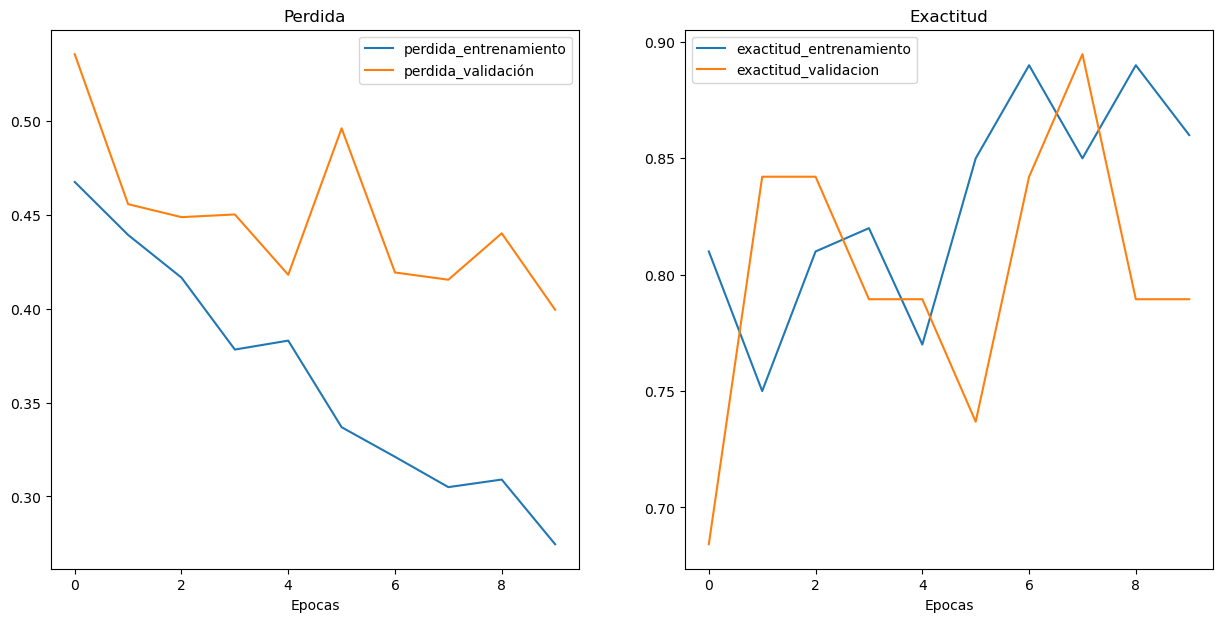

In [89]:
graficar_curvas_perdida(modelo_resultados)

## 6. Guardar el modelo

In [16]:
torch.save(modelo_1.state_dict(), '../modelos/hormiguero_perezoso') 